In [88]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [90]:
season = 'FMA'

### Filename for saved plots

In [91]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [92]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [93]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [94]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [95]:
from bs_fdbck.constants import path_measurement_data

## Settings: 

In [96]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [97]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

In [98]:
ds_smr_sat = xr.open_dataset(sat_filename)

In [99]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 ...
Data variables: (12/19)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    OA (microgram m^-3)                         (time) float64 ...
    N50-500                                     (time) float64 ...
    N100-500                                    (time) float64 ...
    N200-500                                    (time) float64 ...
    day_of_year                                 (time) float64 ...
    hour                                        (time) float64 ...

In [100]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [101]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

In [102]:
ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

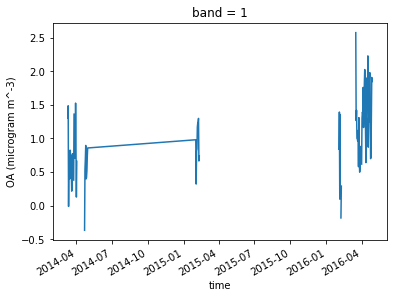

In [103]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [104]:
q33 = ds_smr_sat_JA['OA (microgram m^-3)'].quantile(0.33)
q66 = ds_smr_sat_JA['OA (microgram m^-3)'].quantile(0.66)

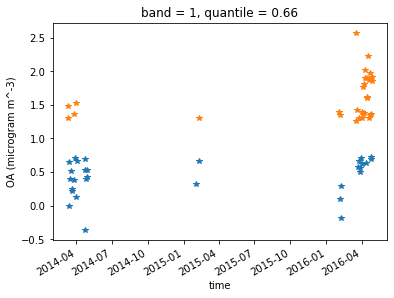

In [105]:
ds_smr_sat_JA.where(ds_smr_sat_JA['OA (microgram m^-3)']<=q33)['OA (microgram m^-3)'].plot(marker='*', linewidth=0)
ds_smr_sat_JA.where(ds_smr_sat_JA['OA (microgram m^-3)']>=q66)['OA (microgram m^-3)'].plot(marker='*', linewidth=0)

#a.isel(LAT=0,LON=0).plot(marker='*', linewidth=0)
#ds_smr_sat_JA['OA (microgram m^-3)'].isel(LAT=0,LON=0).plot(marker='*', linewidth=0)

In [106]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

In [107]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [108]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 625, LAT: 7, LON: 15)
Coordinates:
  * time                 (time) datetime64[ns] 2012-02-01 ... 2018-04-30
  * LAT                  (LAT) float64 -1.5 -2.5 -3.5 -4.5 -5.5 -6.5 -7.5
  * LON                  (LON) float64 -66.5 -65.5 -64.5 ... -54.5 -53.5 -52.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 nan nan nan ... nan nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 nan nan nan ... nan nan nan
    CER (micrometer)     (time, LAT, LON) float32 nan nan nan ... nan nan nan
    COT                  (time, LAT, LON) float32 nan nan nan ... nan nan nan

In [109]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [110]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [111]:
df_smr_sat_JAs#.dropna()

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       LAT  LON                                                          
2014-03-10 -1.5 -64.5             1.305000          62.0         18.480000   
                -59.5             1.305000          87.0         23.109999   
                -58.5             1.305000          84.0         20.480000   
                -57.5             1.305000         104.0         20.930000   
                -56.5             1.305000         115.0         19.070000   
...                                    ...           ...               ...   
2016-04-28 -7.5 -56.5             1.846443         106.0         10.160000   
                -55.5             1.846443          79.0          9.160000   
                -54.5             1.846443         171.0         10.260000   
                -53.5             1.846443         140.0         10.290000   
                -52.5             1.846443         277.0         15.860000   

                             COT  
time       LAT  LON               
2014-03-10 -1.5 -64.5   5.170000  
                -59.5   5.790000  
                -58.5   6.130000  
                -57.5   7.830000  
                -56.5   9.080000  
...                          ...  
2016-04-28 -7.5 -56.5  16.459999  
                -55.5  13.790000  
                -54.5  25.990000  
                -53.5  21.850000  
                -52.5  23.150000  

[3100 rows x 4 columns]

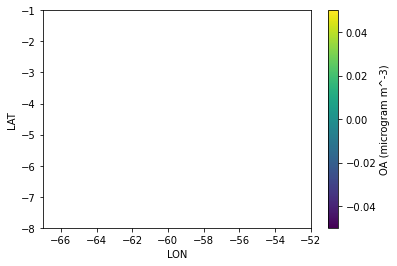

In [112]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [113]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [114]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


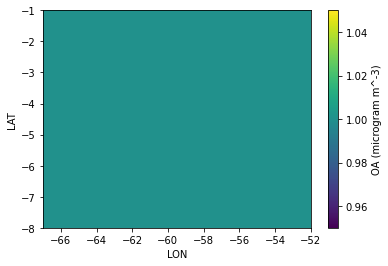

In [115]:
(~da_drop_pixels).plot()

In [116]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

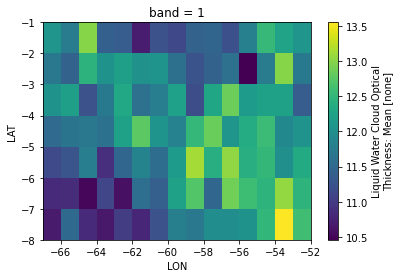

In [117]:
ds_smr_sat_JAs['COT'].mean('time').plot()

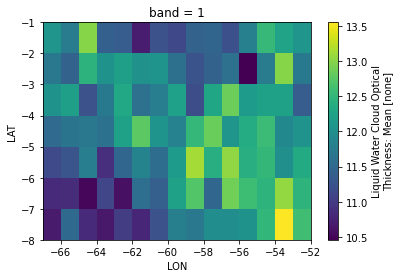

In [118]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([ 210.,  420.,  840., 2520., 1470., 2205.,  525.,  840.,  210.,
         105.]),
 array([-0.3675    , -0.07344975,  0.2206005 ,  0.51465075,  0.808701  ,
         1.10275125,  1.3968015 ,  1.69085175,  1.984902  ,  2.27895225,
         2.5730025 ]),
 <BarContainer object of 10 artists>)

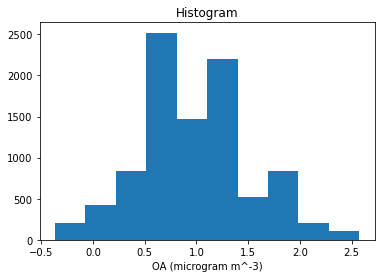

In [119]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [120]:
1-.33333

0.66667

In [121]:
ds_smr_sat_JAs.to_dataframe().dropna()['OA (microgram m^-3)'].quantile([0.3333333,.66666666]).values

array([0.74 , 1.305])

In [122]:
[perc_33, perc_66] = ds_smr_sat_JAs.to_dataframe().dropna()['OA (microgram m^-3)'].quantile([0.3333333,.66666666]).values

In [123]:
perc_33

0.74

In [124]:
perc_66

1.3050000000000002

In [125]:
#df_hyy_1['OA_category']

ds_smr_sat_JAs['OA_low']= ds_smr_sat_JAs['OA (microgram m^-3)']<perc_33
ds_smr_sat_JAs['OA_high']= ds_smr_sat_JAs['OA (microgram m^-3)']>perc_66

df_smr_sat_JAs = ds_smr_sat_JAs.to_dataframe()

df_smr_sat_JAs=df_smr_sat_JAs.assign(OA_category= pd.NA)
df_smr_sat_JAs.loc[df_smr_sat_JAs['OA_high'], 'OA_category'] = 'OA high'
df_smr_sat_JAs.loc[df_smr_sat_JAs['OA_low'], 'OA_category'] = 'OA low'

#ds_smr_sat_JAs['OA_category'][ds_smr_sat_JAs['OA_high']] = 'OA high'

In [126]:
ds_smr_sat_JAs['OA_category']=df_smr_sat_JAs.to_xarray()['OA_category']

In [127]:
ds_smr_sat_JAs['OA_low'].where(ds_smr_sat_JAs['OA_low']).to_dataframe().dropna().count()

band      3465
OA_low    3465
dtype: int64

In [128]:
ds_smr_sat_JAs['OA_low'].where(ds_smr_sat_JAs['OA_low']).to_dataframe().dropna().count()

band      3465
OA_low    3465
dtype: int64

In [129]:
ds_smr_sat_JAs['OA_high'].to_dataframe().dropna().count()

band       65625
OA_high    65625
dtype: int64

In [130]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [131]:
df_hyy_1

,,,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT,OA_low,OA_high,OA_category
time,lat,lon,,,,,,,
2012-02-01,-7.5,-66.5,NaN,127.0,22.769999,9.090000,False,False,<NA>
2012-02-02,-7.5,-66.5,NaN,NaN,NaN,NaN,False,False,<NA>
2012-02-03,-7.5,-66.5,NaN,NaN,NaN,NaN,False,False,<NA>
2012-02-04,-7.5,-66.5,NaN,NaN,NaN,NaN,False,False,<NA>
2012-02-05,-7.5,-66.5,NaN,132.0,17.469999,11.240000,False,False,<NA>
...,...,...,...,...,...,...,...,...,...
2018-04-26,-1.5,-52.5,NaN,193.0,22.080000,13.090000,False,False,<NA>
2018-04-27,-1.5,-52.5,NaN,NaN,NaN,NaN,False,False,<NA>
2018-04-28,-1.5,-52.5,NaN,181.0,20.809999,12.950000,False,False,<NA>


#### Original binning from Yli-Juuti et al:

In [132]:
bins = pd.IntervalIndex.from_tuples([(60, 100), (100, 140), (140, 180), (180, 220), (220, 260), (260, 300), (300, 340)])

labels=[ 80, 120, 160, 200, 240, 280, 320]

df_hyy_1['CWP_cut']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins, labels=labels)
# label for each bin
df_hyy_1['CWP_cutl'] = df_hyy_1['CWP_cut'].apply(lambda x:x.mid)

#### Quantile binning

In [133]:
df_hyy_1['CWP (g m^-2)'].dropna()

time        lat   lon  
2012-02-01  -7.5  -66.5    127.0
2012-02-05  -7.5  -66.5    132.0
2012-02-06  -7.5  -66.5     70.0
2012-02-09  -7.5  -66.5    339.0
2012-02-11  -7.5  -66.5    105.0
                           ...  
2018-04-25  -1.5  -52.5    102.0
2018-04-26  -1.5  -52.5    193.0
2018-04-28  -1.5  -52.5    181.0
2018-04-29  -1.5  -52.5    206.0
2018-04-30  -1.5  -52.5    115.0
Name: CWP (g m^-2), Length: 19230, dtype: float32

In [134]:
df_hyy_1['CWP_qcut']=pd.qcut(df_hyy_1['CWP (g m^-2)'], 7)#bins=bins, labels=labels)
df_hyy_1['CWP_qcutl'] = df_hyy_1['CWP_qcut'].apply(lambda x:x.mid)
# Label by median in each bin
di = dict(df_hyy_1.groupby('CWP_cut').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cutlm'] = df_hyy_1['CWP_cut'].apply(lambda x:di[x])

#### Bin from 5th to 95th quantile of CWP and label by median in each bin or just number

In [135]:
n_bins = 6
labels = np.arange(n_bins)

qants = df_hyy_1['CWP (g m^-2)'].quantile([.0,.90])

bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)

bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
bins2.values[0] = pd.Interval(0,bins2[0].right)


df_hyy_1['CWP_cut2']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins2, labels=labels)


di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

df_hyy_1['CWP_cut2l'] = df_hyy_1['CWP_cut2'].apply(lambda x:di_per_lab[x])


di = dict(df_hyy_1.groupby('CWP_cut2').median()['CWP (g m^-2)'])
for k in di.keys():
    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lm'] = df_hyy_1['CWP_cut2'].apply(lambda x:di[x])
#di = dict(df_hyy_1.groupby('CWP_cut2').mid)
#for k in di.keys():
#    di[k] = int(np.round(di[k]))
df_hyy_1['CWP_cut2lmid'] = df_hyy_1['CWP_cut2'].apply(lambda x:np.round(x.mid))


#df_hyy_1['CWP_cut2lmid'] = df_hyy_1['CWP_cut2'].apply(lambda x:x.mid)

<AxesSubplot:ylabel='Frequency'>

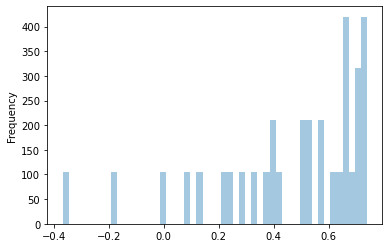

In [136]:
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')



#df_hyy_1_old['OA (microgram m^-3)'][df_hyy_1_old['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')



In [137]:
vs =['OA (microgram m^-3)', 'CWP (g m^-2)', 'CER (micrometer)', 'COT',
       'OA_low', 'OA_high', 'OA_category']

df_smr_sat_JAsad model data:

## Load model data

In [138]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth' 

models =[model_name_noresm,model_name_echam,model_name_ec_earth]

### Settings

In [139]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

In [140]:
l=-10
((l)%360)

350

In [141]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

In [142]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

### NorESM

In [143]:


lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

In [144]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [145]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files created in [02-create_file-long_sum.ipynb](02-create_file-long_sum)

#### Input files

In [146]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [147]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [148]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [149]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [150]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [151]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [152]:
cases_echam = [case_name_echam]

### EC-Earth

In [153]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [154]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [155]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [156]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [157]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [158]:
cases_ec_earth = [case_name_ec_earth]

### Read in model data

In [159]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2] )

df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2] )
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2] )

In [160]:
df_mod_ec_earth.to_xarray()

<xarray.Dataset>
Dimensions:                   (time: 2558, lat: 10, lon: 22)
Coordinates:
  * time                      (time) object '2011-12-31' ... '2018-12-31'
  * lat                       (lat) float64 -7.37 -6.67 -5.96 ... -1.75 -1.05
  * lon                       (lon) float64 293.2 293.9 294.6 ... 307.3 308.0
Data variables: (12/106)
    station                   (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO'
    cdnc_incld                (time, lat, lon) float64 nan nan nan ... nan nan
    re_liq                    (time, lat, lon) float64 nan nan ... 3.995 3.858
    cc_cltop                  (time, lat, lon) float64 nan nan ... 0.7031 0.9766
    argmax                    (time, lat, lon) float64 nan nan ... -20.0 -19.0
    r_eff                     (time, lat, lon) float64 nan nan ... 21.5 25.01
    ...                        ...
    RDRY_AIS                  (time, lat, lon) float64 nan nan ... 15.81 15.81
    M_SOAACS                  (time, lat, lon) float64 nan nan ... 1.394 1.394
    DWET_ACI                  (time, lat, lon) float64 nan nan ... 378.3 378.3
    M_BCCOS                   (time, lat, lon) float64 nan nan ... 2.581e-14
    N_AII                     (time, lat, lon) float64 nan nan ... 185.5 185.5
    year                      (time, lat, lon) int64 2011 2011 ... 2018 2018

## Pick out months:

In [161]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]

### Organize data in dictionary

In [162]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df['Observations'] = df_hyy_1

## Mask data

### NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top 

In [163]:
df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.05) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)

df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

### Scale CWP down for EC-Earth

In [164]:
_df = dic_df[model_name_ec_earth]
_df = _df.rename({'CWP':'CWP_orig'}, axis=1)
dic_df[model_name_ec_earth]  = _df

In [165]:
_df = dic_df[model_name_ec_earth]

if 'scaled' not in _df.columns:
    _df['CWP'] = _df['CWP_orig']*.7
    
    _df['scaled'] = True
dic_df[model_name_ec_earth]  = _df

## Rename variables:


In [166]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    
    
}
rn_dic_ec_earth = {
    
  # 'tclw':'CWP',
}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}



In [167]:
for key, rn in zip([model_name_noresm, model_name_echam, model_name_ec_earth,'Observations'], 
                   [rn_dic_noresm, rn_dic_echam,rn_dic_ec_earth, rn_dic_obs]):
    dic_df[key] = dic_df[key].rename(rn, axis=1)

## Group by cloud water path 

#### Predefined bins

In [168]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])

### Bin model data:

CWP above 50. 

In [169]:
varl_categories = ['OA']#,'CLDFREE']

In [170]:
varl_categories

['OA']

In [171]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'Observations'])

In [172]:
dic_df['EC-Earth'][['CWP']]

CWP
time       lat   lon               
2012-02-01 -7.37 293.20  142.828371
                 293.91   79.681399
                 294.61  286.596681
                 295.31         NaN
                 296.02         NaN
...                             ...
2018-04-30 -1.05 305.16  120.318961
                 305.86         NaN
                 306.56         NaN
                 307.27         NaN
                 307.97         NaN

[137500 rows x 1 columns]

In [173]:
ds_ec = dic_df['EC-Earth']#.to_xarray()

In [174]:
ds_no = dic_df['NorESM'].to_xarray()

In [175]:
7*12/(10*22)

0.38181818181818183

In [176]:
ds_no

<xarray.Dataset>
Dimensions:            (time: 591, lat: 7, lon: 12)
Coordinates:
  * time               (time) object '2012-02-01' '2012-02-02' ... '2018-04-30'
  * lat                (lat) float64 -7.068 -6.126 -5.183 ... -2.356 -1.414
  * lon                (lon) float64 293.8 295.0 296.2 ... 305.0 306.2 307.5
Data variables: (12/103)
    station            (time, lat, lon) object nan nan nan ... 'ATTO' 'ATTO' nan
    FSDS_DRF           (time, lat, lon) float64 nan nan nan ... 450.6 620.4 nan
    FSUTADRF           (time, lat, lon) float64 nan nan nan ... 540.8 156.7 nan
    FLUTC              (time, lat, lon) float64 nan nan nan ... 268.3 274.9 nan
    FCTI               (time, lat, lon) float64 nan nan nan nan ... 0.0 0.0 nan
    FSDSCDRF           (time, lat, lon) float64 nan nan nan ... 927.2 757.3 nan
    ...                 ...
    SS_A2              (time, lat, lon) float64 nan nan nan ... 2.472e-11 nan
    SFmonoterp         (time, lat, lon) float64 nan nan nan ... 1.594e-10 nan
    SO4_A1             (time, lat, lon) float64 nan nan nan ... 0.002579 nan
    N150-500           (time, lat, lon) float64 nan nan nan ... 93.08 93.08 nan
    year               (time, lat, lon) float64 nan nan nan ... 2.018e+03 nan
    mask_liq_cloudtop  (time, lat, lon) object nan nan nan nan ... True True nan

In [177]:
n_bins = 6

for model_name in models:
    print(model_name)
    df_mod = dic_df[model_name]
    

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.90])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)
 
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)
        
        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( df_mod[v].quantile(.34)<df_mod[v]) & (df_mod[v]<df_mod[v].quantile(.66))
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'
        dic_df[model_name] = df_mod

NorESM
3.36738035
5.5497505
ECHAM-SALSA
0.820723885
1.91418405
EC-Earth
1.4356830934154343
1.8464910243639847


## Quantile cut

In [178]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

# Distribution plots:

In [179]:
palette = 'Set2'

In [180]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

In [181]:
for key in dic_df.keys():
    _df = dic_df[key].copy()
    #_df = _df[_df[v_x]<x_cut]
    print(key)
    print(len(_df.dropna().reset_index()['time'].unique()))
    #_df.reset_index()['time'].unique().plot()

ECHAM-SALSA
416
NorESM
371
EC-Earth
410
Observations
58


19230
Plots/dist_plot/cloud_props_distribution_mod_obs_COT_count_FMA.png


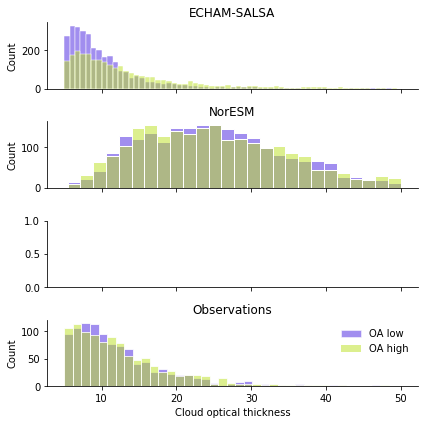

In [182]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    if key=='EC-Earth':
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



19135
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_FMA.png


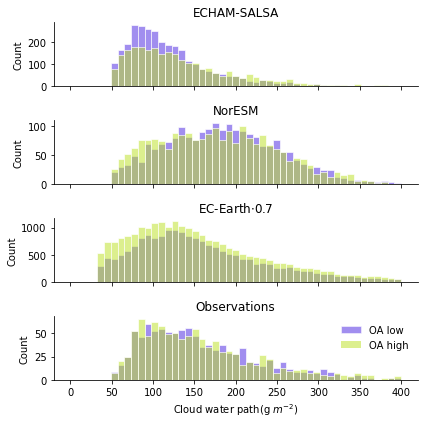

In [183]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,400)
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1005
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_FMA.png


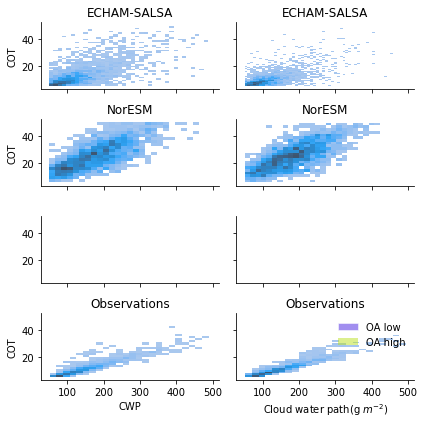

In [184]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    if key=='EC-Earth':
        continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1005
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_FMA.png


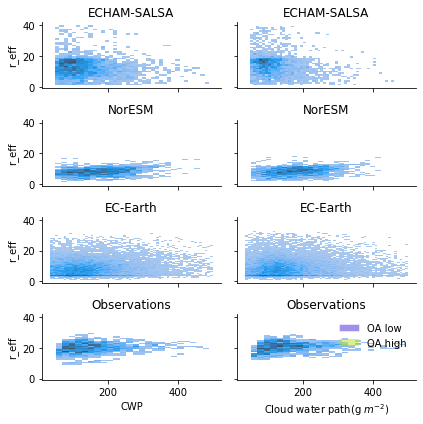

In [185]:
fig, axs = plt.subplots(4,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'r_eff'
x_cut = 500
y_cut = 40
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    #if key=='EC-Earth':
    #    continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_y]<y_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [186]:
hue_v = 'OA high'

19135
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_FMA.png


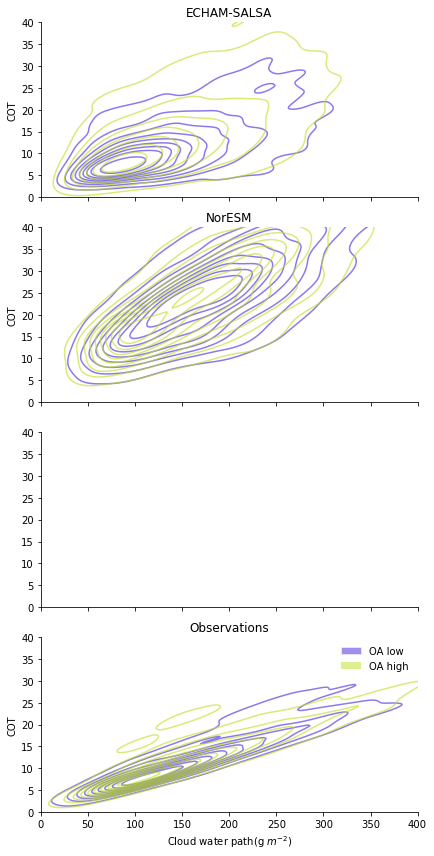

In [187]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key=='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,40])    

19230
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_FMA.png


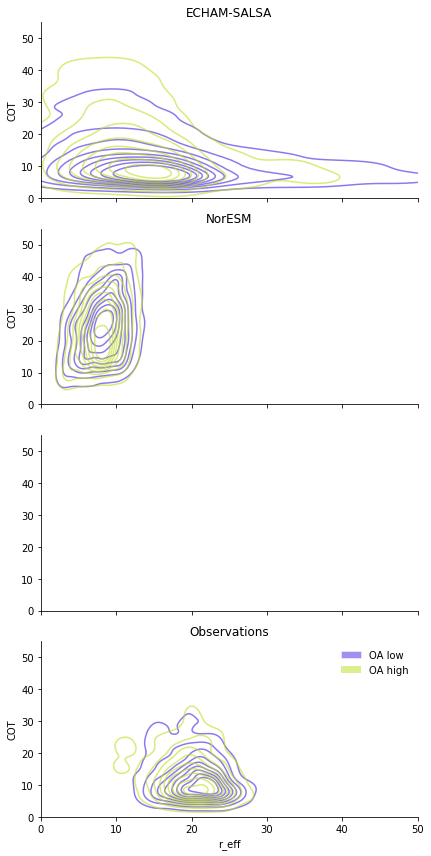

In [188]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'r_eff'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key =='EC-Earth':
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel(v_x)
ax.set_ylabel(v_y)

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,50])
    ax.set_ylim([0,55])    

19135
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_FMA.png


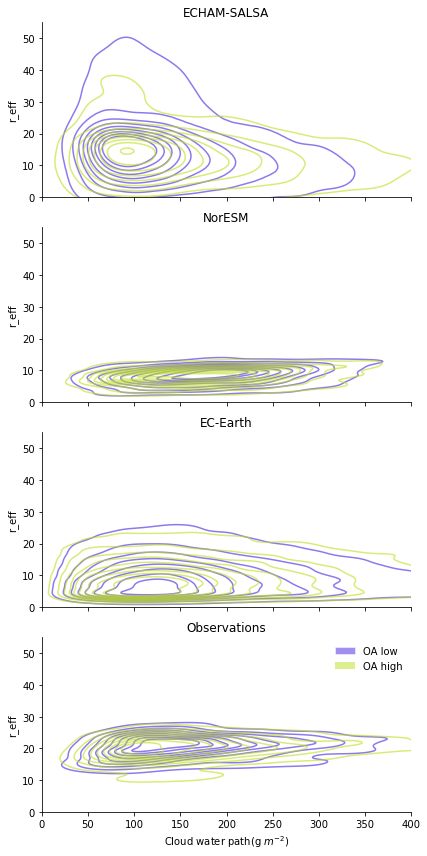

In [189]:
fig, axs = plt.subplots(4,1,  figsize =[6,12], sharex=True, sharey=True)

v_y = 'r_eff'
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,55])    

In [190]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

8511

In [191]:
len(dic_df['ECHAM-SALSA'].dropna())

5257

In [192]:
len(dic_df['NorESM'].dropna())

4389

4232
6599
55134
19230
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_FMA.png


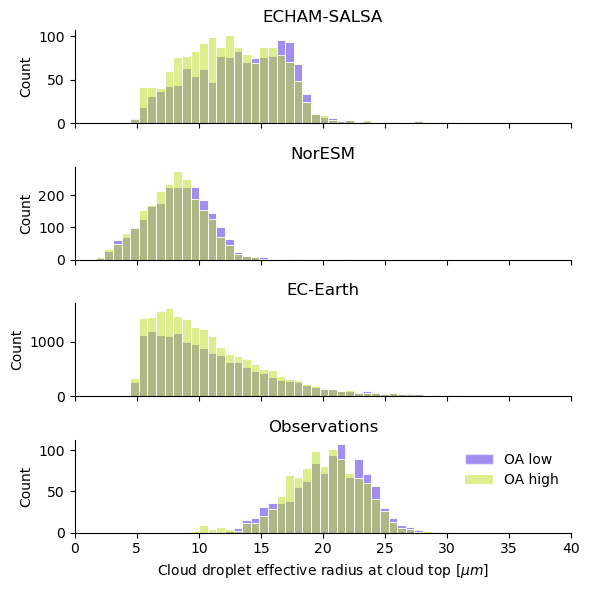

In [222]:
fig, axs = plt.subplots(4,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
_bins = np.linspace(1, 35)
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        bins = _bins,
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [194]:
df_ec_earth = dic_df['EC-Earth']
df_ec_earth = df_ec_earth[df_ec_earth['r_eff']>=5]
dic_df['EC-Earth'] = df_ec_earth

In [195]:
ds_ech = dic_df['ECHAM-SALSA'].to_xarray()

In [196]:
ds_nor = dic_df['NorESM'].to_xarray()

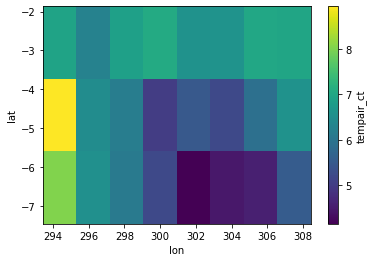

In [197]:
(ds_ech['tempair_ct'].mean('time')-273.15).plot()

In [198]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 625, lat: 3, lon: 8)
Coordinates:
  * time            (time) object '2012-02-01' '2012-02-02' ... '2018-04-30'
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/67)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    ceff_ct         (time, lat, lon) float64 10.38 17.06 nan ... nan 6.866 13.3
    lcdnc_ct_incld  (time, lat, lon) float64 3.595e+06 1.009e+06 ... 1.262e+07
    lcdnc_ct        (time, lat, lon) float64 1.566e+06 1.009e+06 ... 1.252e+07
    lcdnc_ct_cm3    (time, lat, lon) float64 1.566 1.009 nan ... nan 12.3 12.52
    ceff            (time, lat, lon) float64 0.0 0.0 nan 0.0 ... 0.0 nan 0.0 0.0
    ...              ...
    OA_low          (time, lat, lon) bool False False False ... True True True
    OA_high         (time, lat, lon) bool False False False ... False False
    OA_mid_range    (time, lat, lon) bool True True True ... False False False
    OA_category     (time, lat, lon) object <NA> <NA> <NA> ... 'OA low' 'OA low'
    CWP_qcut        (time, lat, lon) object (111.779, 136.12] ... (136.12, 17...
    CWP_qcutl       (time, lat, lon) float64 123.9 102.2 nan ... nan 102.2 157.6

In [199]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 625, lat: 3, lon: 8)
Coordinates:
  * time            (time) object '2012-02-01' '2012-02-02' ... '2018-04-30'
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/67)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    ceff_ct         (time, lat, lon) float64 10.38 17.06 nan ... nan 6.866 13.3
    lcdnc_ct_incld  (time, lat, lon) float64 3.595e+06 1.009e+06 ... 1.262e+07
    lcdnc_ct        (time, lat, lon) float64 1.566e+06 1.009e+06 ... 1.252e+07
    lcdnc_ct_cm3    (time, lat, lon) float64 1.566 1.009 nan ... nan 12.3 12.52
    ceff            (time, lat, lon) float64 0.0 0.0 nan 0.0 ... 0.0 nan 0.0 0.0
    ...              ...
    OA_low          (time, lat, lon) bool False False False ... True True True
    OA_high         (time, lat, lon) bool False False False ... False False
    OA_mid_range    (time, lat, lon) bool True True True ... False False False
    OA_category     (time, lat, lon) object <NA> <NA> <NA> ... 'OA low' 'OA low'
    CWP_qcut        (time, lat, lon) object (111.779, 136.12] ... (136.12, 17...
    CWP_qcutl       (time, lat, lon) float64 123.9 102.2 nan ... nan 102.2 157.6

In [200]:
ds_nor['COT'].count()

<xarray.DataArray 'COT' ()>
array(6599)

In [201]:
ds_ech.where(ds_ech['cl_time_ct']>.9)['COT'].count()

<xarray.DataArray 'COT' ()>
array(4558)

In [202]:
ds_ech

<xarray.Dataset>
Dimensions:         (time: 625, lat: 3, lon: 8)
Coordinates:
  * time            (time) object '2012-02-01' '2012-02-02' ... '2018-04-30'
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/67)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    ceff_ct         (time, lat, lon) float64 10.38 17.06 nan ... nan 6.866 13.3
    lcdnc_ct_incld  (time, lat, lon) float64 3.595e+06 1.009e+06 ... 1.262e+07
    lcdnc_ct        (time, lat, lon) float64 1.566e+06 1.009e+06 ... 1.252e+07
    lcdnc_ct_cm3    (time, lat, lon) float64 1.566 1.009 nan ... nan 12.3 12.52
    ceff            (time, lat, lon) float64 0.0 0.0 nan 0.0 ... 0.0 nan 0.0 0.0
    ...              ...
    OA_low          (time, lat, lon) bool False False False ... True True True
    OA_high         (time, lat, lon) bool False False False ... False False
    OA_mid_range    (time, lat, lon) bool True True True ... False False False
    OA_category     (time, lat, lon) object <NA> <NA> <NA> ... 'OA low' 'OA low'
    CWP_qcut        (time, lat, lon) object (111.779, 136.12] ... (136.12, 17...
    CWP_qcutl       (time, lat, lon) float64 123.9 102.2 nan ... nan 102.2 157.6

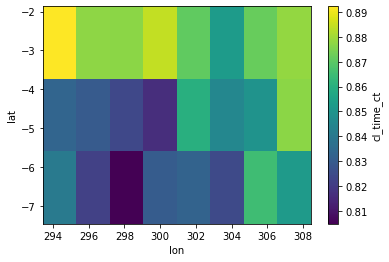

In [203]:
(ds_ech['cl_time_ct'].mean('time')).plot()#vmin=100, vmax=160)

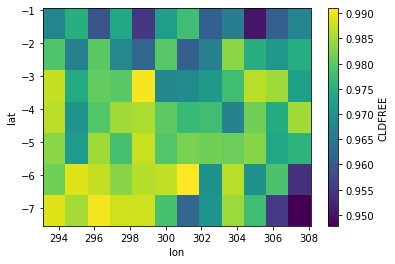

In [204]:
(1-ds_nor['CLDFREE'].mean('time')).plot()

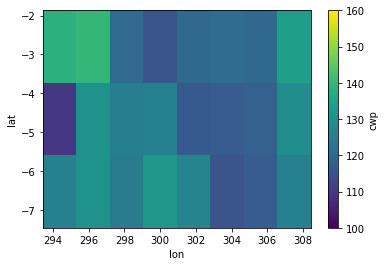

In [205]:
(ds_ech['cwp'].mean('time')).plot(vmin=100, vmax=160)

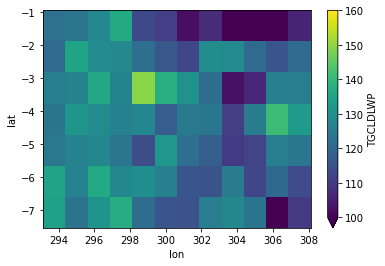

In [206]:
(ds_nor['TGCLDLWP'].mean('time')).plot(vmin=100, vmax=160)

In [207]:
dic_df[model_name_echam] = dic_df[model_name_echam][dic_df[model_name_echam]['cl_time_ct']>0.9]
dic_df[model_name_echam]

station    ceff_ct  lcdnc_ct_incld    lcdnc_ct  \
time       lat       lon                                                      
2012-02-01 -2.797890 300.000    ATTO   8.281203      30812434.0  30812434.0   
                     301.875    ATTO   2.541879       3524118.5   3524118.5   
                     303.750    ATTO  23.460506      11807518.0  11807518.0   
           -6.528409 296.250    ATTO  17.064156       1009445.9   1009445.9   
                     300.000    ATTO  13.627315       1769051.8   1769051.8   
...                              ...        ...             ...         ...   
2018-04-30 -6.528409 296.250    ATTO   8.881983       1320770.1   1320770.1   
                     300.000    ATTO  12.076321       4366383.0   4366383.0   
                     303.750    ATTO  15.125526      10000000.0  10000000.0   
                     305.625    ATTO  14.988315      18421602.0  15605278.0   
                     307.500    ATTO  14.292677       1596116.2   1346770.5   

                              lcdnc_ct_cm3      ceff         CWP  cl_time_ct  \
time       lat       lon                                                       
2012-02-01 -2.797890 300.000     30.812433  0.000000  140.965960      1.0000   
                     301.875      3.524119  0.000005  262.909030      1.0000   
                     303.750     11.807518  0.000000  123.301994      1.0000   
           -6.528409 296.250      1.009446  0.000000   96.623770      1.0000   
                     300.000      1.769052  0.000000  118.124860      1.0000   
...                                    ...       ...         ...         ...   
2018-04-30 -6.528409 296.250      1.320770  0.000000  168.058850      1.0000   
                     300.000      4.366383  0.000000   99.036380      1.0000   
                     303.750     10.000000  0.000000  127.053980      1.0000   
                     305.625     15.605278  0.000000  148.824080      0.9375   
                     307.500      1.346771  0.000000  205.304630      1.0000   

                              clfr_mask     clfr  ...  \
time       lat       lon                          ...   
2012-02-01 -2.797890 300.000        1.0  0.00000  ...   
                     301.875        1.0  0.08004  ...   
                     303.750        1.0  0.00000  ...   
           -6.528409 296.250        1.0  0.00000  ...   
                     300.000        1.0  0.00000  ...   
...                                 ...      ...  ...   
2018-04-30 -6.528409 296.250        1.0  0.00000  ...   
                     300.000        1.0  0.00000  ...   
                     303.750        1.0  0.00000  ...   
                     305.625        1.0  0.00000  ...   
                     307.500        1.0  0.00000  ...   

                                                              CWP_cut2  \
time       lat       lon                                                 
2012-02-01 -2.797890 300.000          (130.707835, 157.60918333333333]   
                     301.875                 (184.51053166666665, inf]   
                     303.750          (103.80648666666667, 130.707835]   
           -6.528409 296.250   (76.90513833333333, 103.80648666666667]   
                     300.000          (103.80648666666667, 130.707835]   
...                                                                ...   
2018-04-30 -6.528409 296.250  (157.60918333333333, 184.51053166666665]   
                     300.000   (76.90513833333333, 103.80648666666667]   
                     303.750          (103.80648666666667, 130.707835]   
                     305.625          (130.707835, 157.60918333333333]   
                     307.500                 (184.51053166666665, inf]   

                              CWP_cut2l  CWP_cut2lm  CWP_cut2lmid  OA_low  \
time       lat       lon                                                    
2012-02-01 -2.797890 300.000          3         142         144.0   False   
                     301

In [208]:
dic_df[model_name_echam] = dic_df[model_name_echam][dic_df[model_name_echam]['r_eff']>5]

# Calculate difference between high OA and low


In [209]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [210]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [211]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [212]:
from sklearn.utils import resample

## Bootstrap resampling 

In [213]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [214]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations = 1000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key =='EC-Earth') and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
415
length of 66 is 236 and 277
number of days is 132 and 150
1000
length of 90 is 366 and 310
number of days is 182 and 152
1000
length of 116 is 261 and 250
number of days is 147 and 143
1000
length of 142 is 150 and 198
number of days is 111 and 122
1000
length of 169 is 92 and 128
number of days is 68 and 93
1000
length of 227 is 175 and 319
number of days is 99 and 147
1000
NorESM
Total number of days:
371
length of 73 is 162 and 249
number of days is 89 and 114
1000
length of 108 is 310 and 336
number of days is 133 and 131
1000
length of 144 is 400 and 384
number of days is 138 and 148
1000
length of 182 is 456 and 398
number of days is 152 and 144
1000
length of 219 is 379 and 373
number of days is 139 and 131
1000
length of 274 is 483 and 459
number of days is 144 and 139
1000
EC-Earth
Observations
Total number of days:
58
length of 75 is 124 and 136
number of days is 27 and 26
1000
length of 102 is 221 and 234
number of days is 32 and 26
1000

# Final plot: 

Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_FMA.png


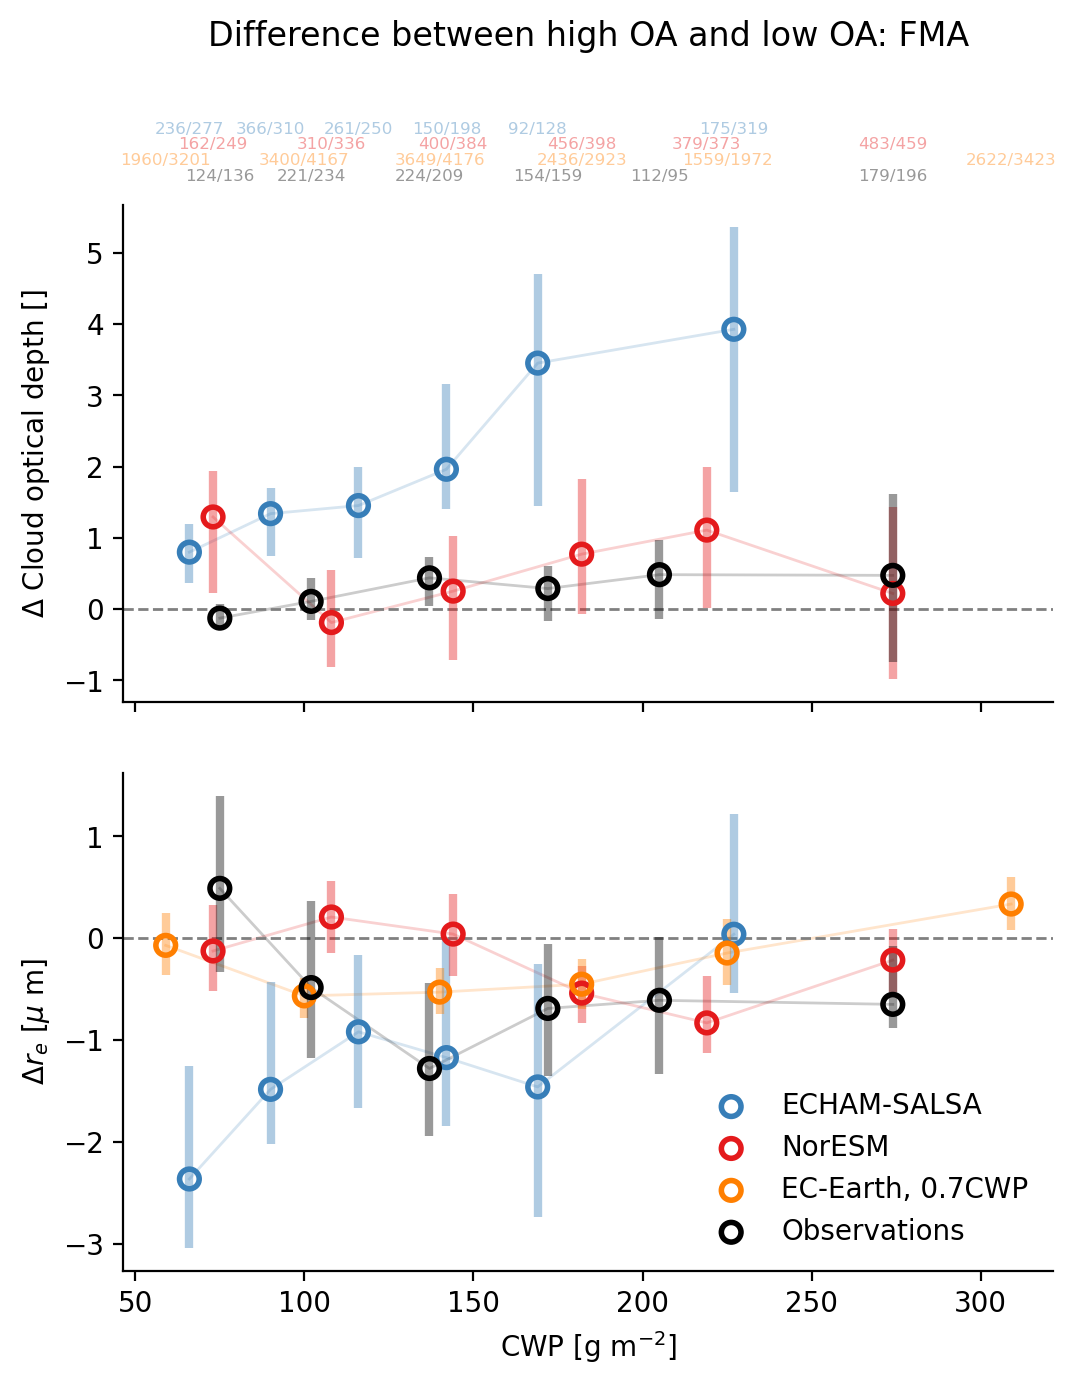

In [215]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical depth []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0


ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in dic_df.keys():
        if (key=='EC-Earth') and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        if key=='EC-Earth':
            label = f'{key}, 0.7CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.4,
                   )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn) 

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [216]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [217]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_FMA.png


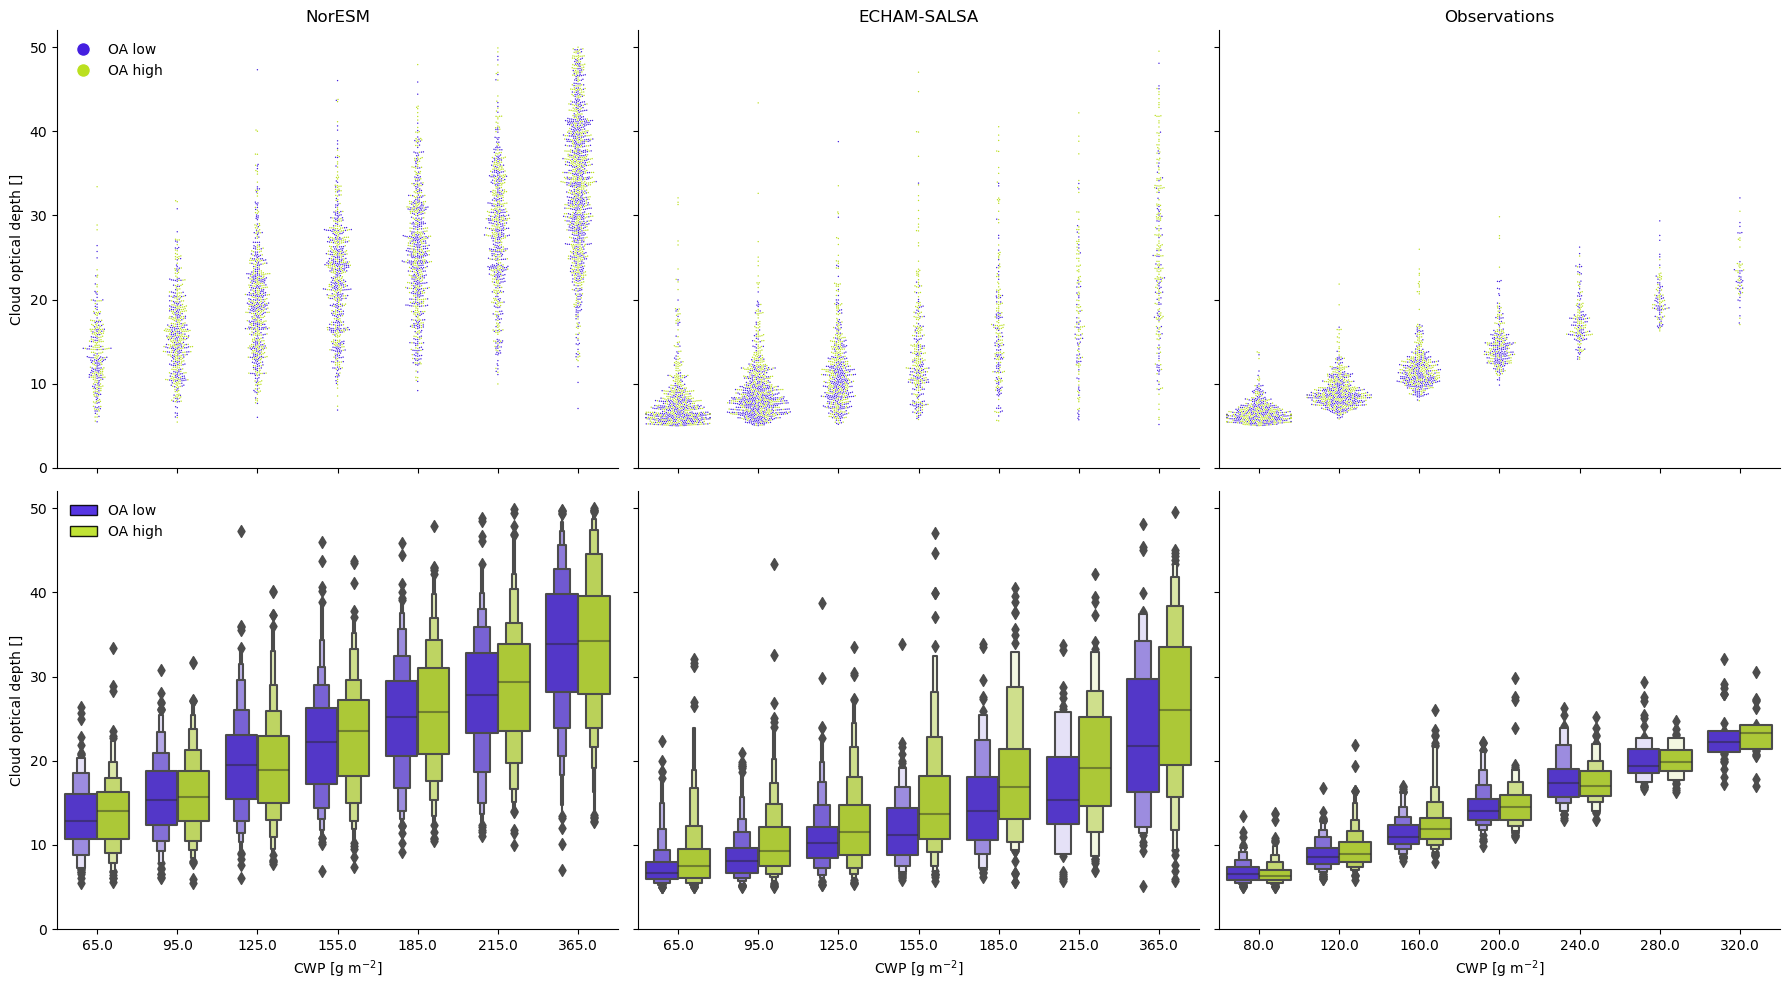

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_FMA.png


In [218]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 1



for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_FMA.png


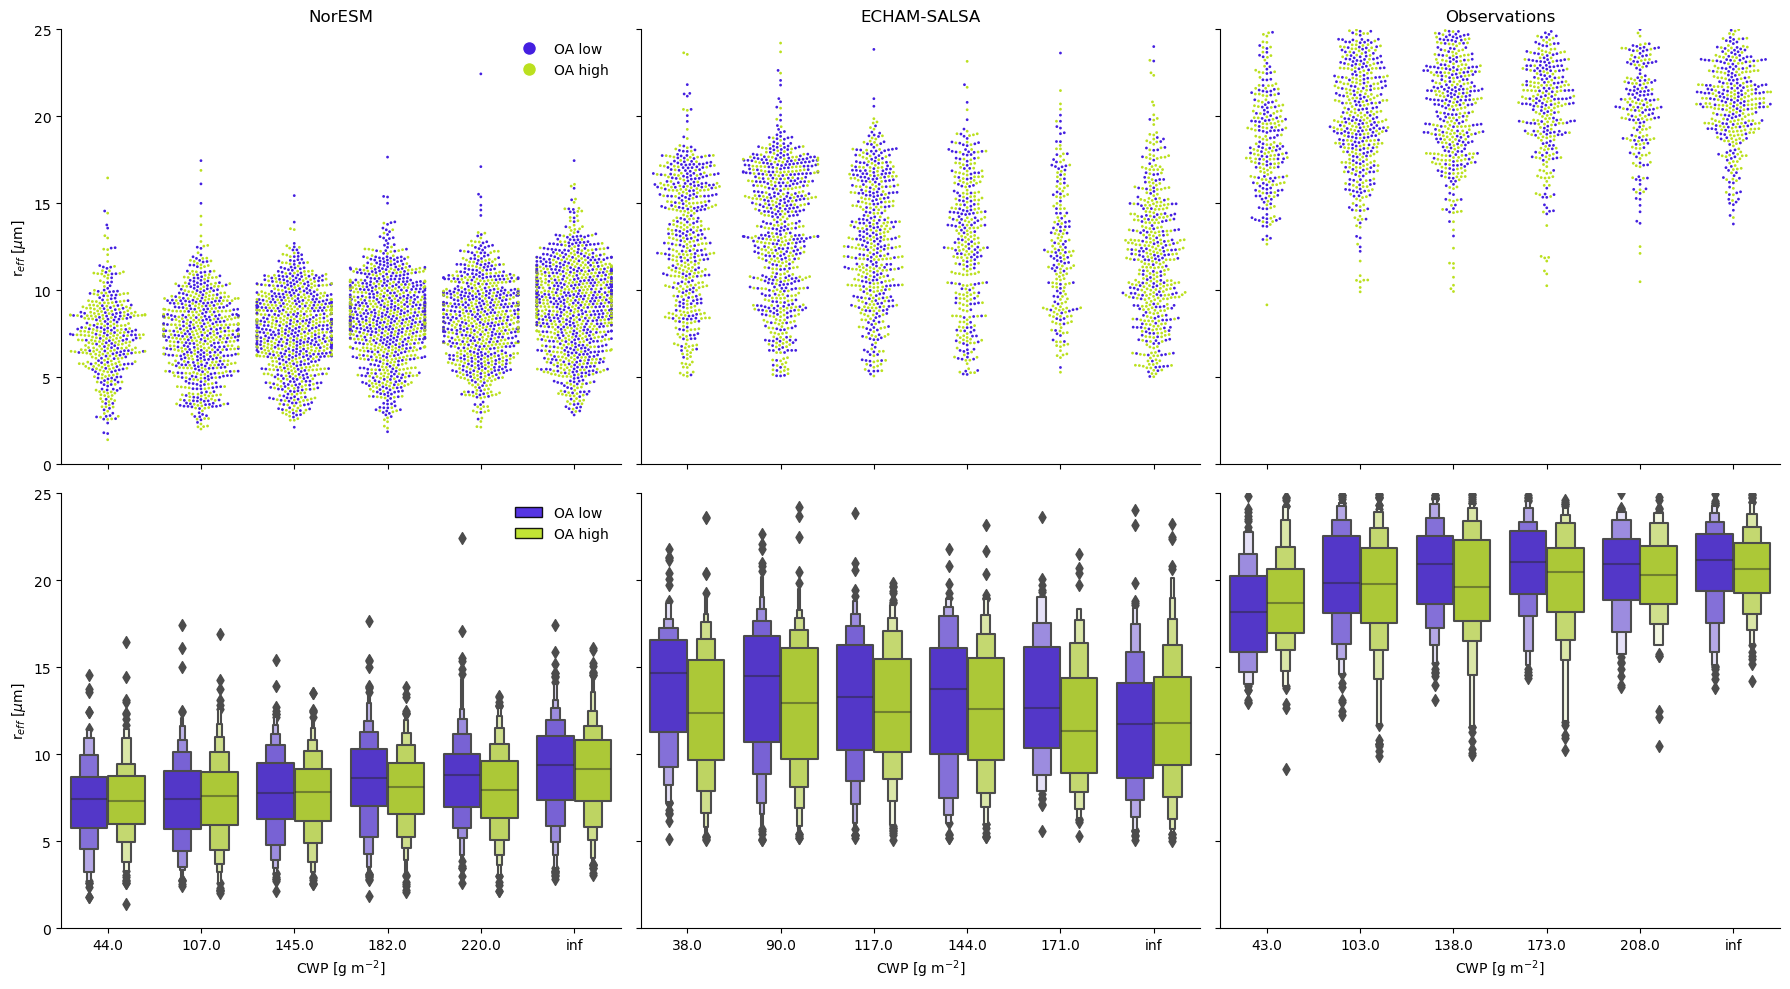

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_FMA.png


In [219]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_FMA.png


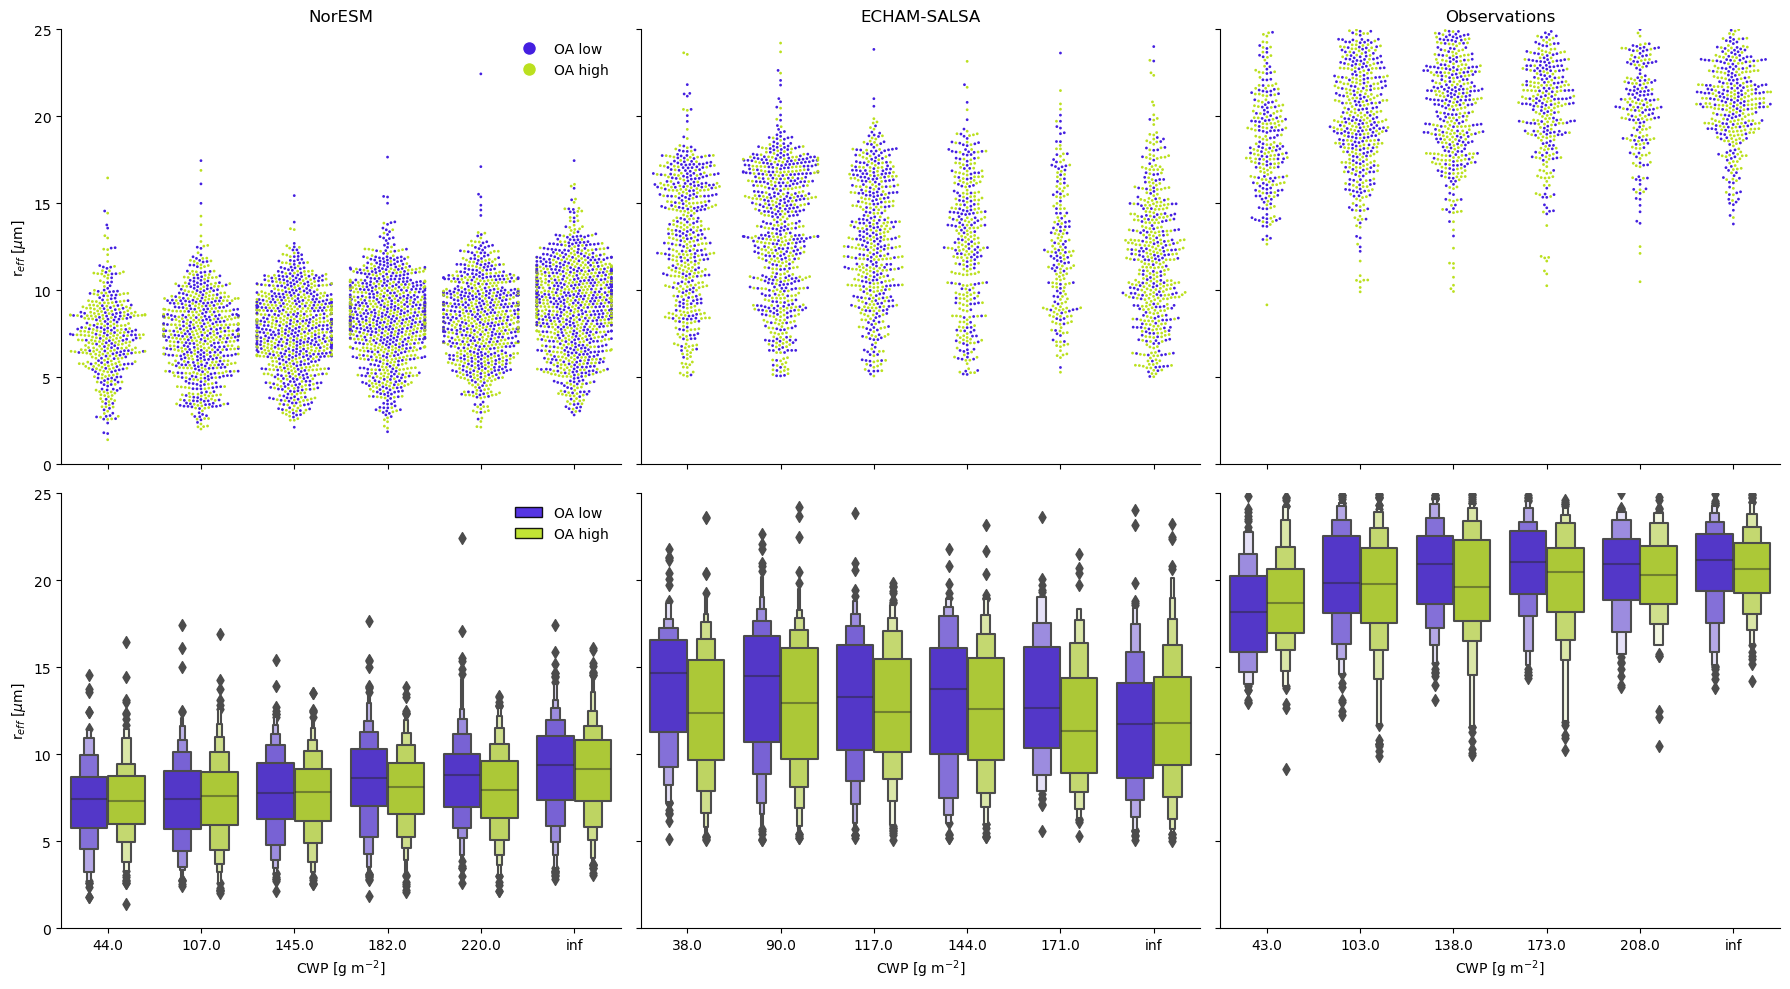

In [220]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

length of 68 is 278 and 314
number of days is 143 and 159
10000
length of 95 is 390 and 340
number of days is 183 and 159
10000
length of 124 is 267 and 259
number of days is 152 and 145
10000
length of 153 is 122 and 192
number of days is 93 and 115
10000
length of 184 is 88 and 122
number of days is 64 and 89
10000
length of 214 is 53 and 91
number of days is 43 and 67
10000
length of 268 is 78 and 164
number of days is 56 and 91
10000


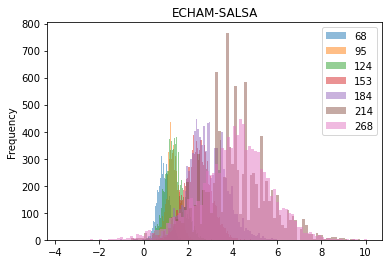

length of 68 is 126 and 172
number of days is 79 and 91
10000
length of 96 is 209 and 278
number of days is 106 and 119
10000
length of 126 is 295 and 291
number of days is 122 and 127
10000
length of 156 is 317 and 292
number of days is 130 and 130
10000
length of 185 is 367 and 321
number of days is 145 and 130
10000
length of 214 is 314 and 302
number of days is 130 and 120
10000
length of 266 is 562 and 543
number of days is 152 and 151
10000


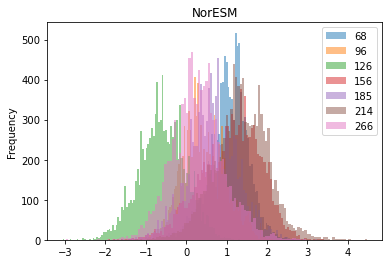

KeyError: 'COT'

In [221]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 10000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()